In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')
plt.ion()
%matplotlib inline

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [18]:
print(" FASE 1: CARGA Y EXPLORACIÓN INICIAL\n")

ruta = "D:/RENATO/Desktop/data/peru_student_enrollment_data_2023.csv"

try:
    df = pd.read_csv(ruta, encoding='utf-8', sep=';')
    print("✓ Dataset cargado exitosamente")
    print(f"  └─ Dimensiones: {df.shape[0]:,} filas x {df.shape[1]} columnas\n")
except Exception as e:
    print(f"❌ Error al cargar el dataset: {e}")

# Vista previa
print(" Primeras 5 filas del dataset:")
print(df.head())
print("\n" + "-"*90 + "\n")

# Información de columnas
print(" Información de columnas:")
print(df.info())
print("\n" + "-"*90 + "\n")

# Valores únicos por columna
print(" Valores únicos por columna:")
for col in df.columns:
    print(f"  {col:40s}: {df[col].nunique():6,} valores únicos")
print("\n" + "="*90 + "\n")

 FASE 1: CARGA Y EXPLORACIÓN INICIAL

✓ Dataset cargado exitosamente
  └─ Dimensiones: 37,582 filas x 21 columnas

 Primeras 5 filas del dataset:
  ENROLLMENT  TUITION PAYMENT MARCH 2022  TUITION PAYMENT MARCH 2023 GENDER  \
0      Nuevo                           0                           0      M   
1      Nuevo                           1                           0      M   
2      Nuevo                           1                           1      F   
3      Nuevo                           0                           0      F   
4      Nuevo                           1                           1      F   

  TYPE OF EDUCATIONAL INSTITUTION EDUCATIONAL INSTITUTION INSTITUTION STATUS  \
0                       INSTITUTO                    IDAT            PRIVADA   
1                         COLEGIO            COLEGIO SISE            PRIVADA   
2                             NaN                     NaN                NaN   
3                         COLEGIO   1220 SAN JOSE MARELLO  

In [19]:
# Crear copia de trabajo
df_clean = df.copy()

# Verificar y reportar valores nulos
print(" Valores nulos por columna:")
null_counts = df_clean.isnull().sum()
null_pct = (null_counts / len(df_clean)) * 100
null_df = pd.DataFrame({
    'Nulos': null_counts,
    'Porcentaje': null_pct
}).sort_values('Nulos', ascending=False)
print(null_df[null_df['Nulos'] > 0])

if null_df['Nulos'].sum() == 0:
    print("  ✓ No se encontraron valores nulos")
print("\n")

# Convertir columnas numéricas
numeric_cols = ['TUITION PAYMENT MARCH 2022', 'NUMBER OF ENROLLED COURSE']
for col in numeric_cols:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
        print(f"✓ Columna '{col}' convertida a numérico")

# Estandarizar nombres de columnas
df_clean.columns = df_clean.columns.str.strip()

# Remover duplicados si existen
duplicates = df_clean.duplicated().sum()
if duplicates > 0:
    df_clean = df_clean.drop_duplicates()
    print(f"\n  Eliminados {duplicates} registros duplicados")
else:
    print(f"\n✓ No se encontraron duplicados")

print(f"\n✓ Dataset limpio: {df_clean.shape[0]:,} registros")
print("\n" + "="*90 + "\n")

 Valores nulos por columna:
                                 Nulos  Porcentaje
TYPE OF EDUCATIONAL INSTITUTION  21714   57.777660
INSTITUTION STATUS               21714   57.777660
EDUCATIONAL INSTITUTION          19370   51.540631
DEPARTMENT                         736    1.958384
PROVINCE                           736    1.958384
DISTRICT                           736    1.958384
SHIFT/SCHEDULE                      58    0.154329
AGE RANGE OF ENROLLED STUDENT        4    0.010643
GENDER                               2    0.005322
CLASSIFICATION                       1    0.002661
FACULTY                              1    0.002661
PROGRAM/MAJOR                        1    0.002661


✓ Columna 'TUITION PAYMENT MARCH 2022' convertida a numérico

  Eliminados 1112 registros duplicados

✓ Dataset limpio: 36,470 registros




 3.1 ESTADÍSTICAS GENERALES

Total de estudiantes matriculados: 36,470

                                   count unique                     top  \
ENROLLMENT                         36470      3              Reinscrito   
TUITION PAYMENT MARCH 2022       36470.0    NaN                     NaN   
TUITION PAYMENT MARCH 2023       36470.0    NaN                     NaN   
GENDER                             36468      5                       M   
TYPE OF EDUCATIONAL INSTITUTION    15826      3                 COLEGIO   
EDUCATIONAL INSTITUTION            18163   4122             UNIVERSIDAD   
INSTITUTION STATUS                 15826      2                 PRIVADA   
DEPARTMENT                         35779     25                    LIMA   
PROVINCE                           35779    165                    LIMA   
DISTRICT                           35779    694  SAN JUAN DE LURIGANCHO   

                                  freq      mean       std  min  25%  50%  \
ENROLLMENT               

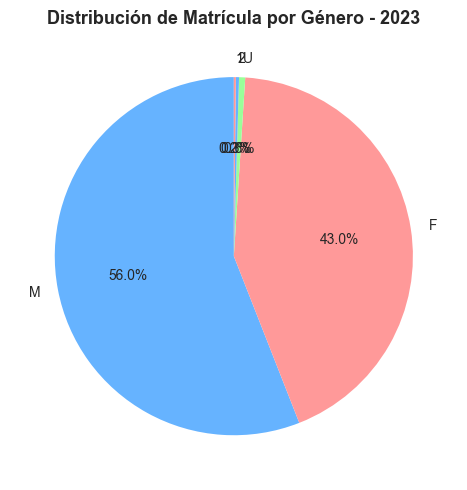

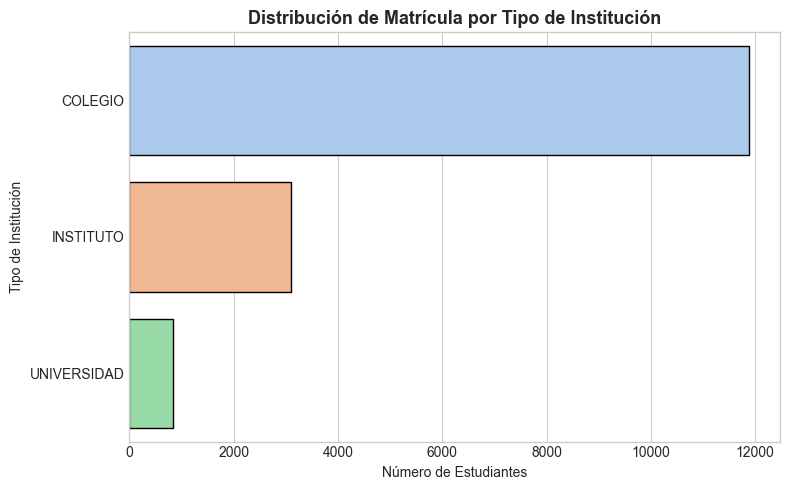

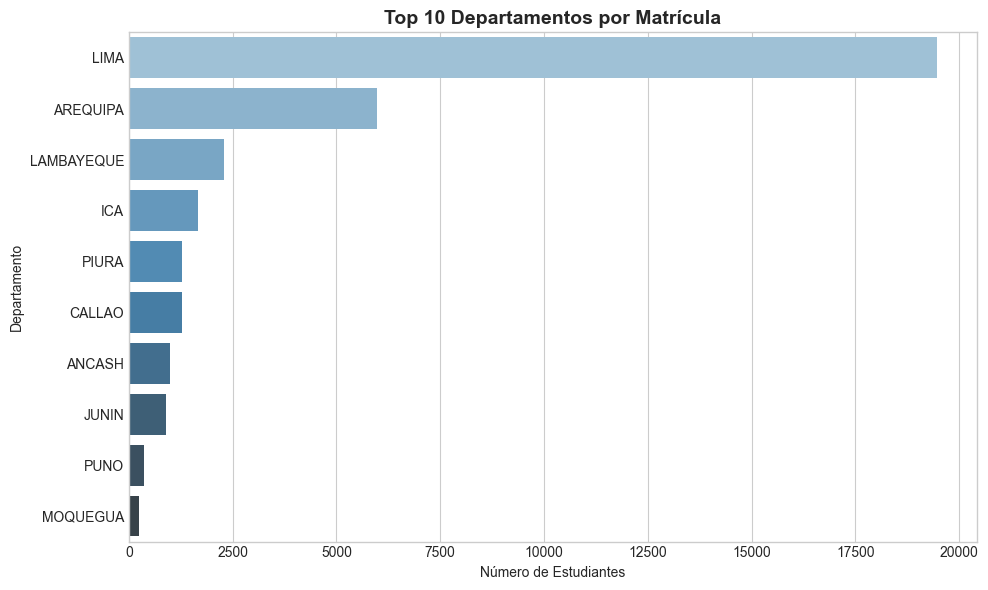

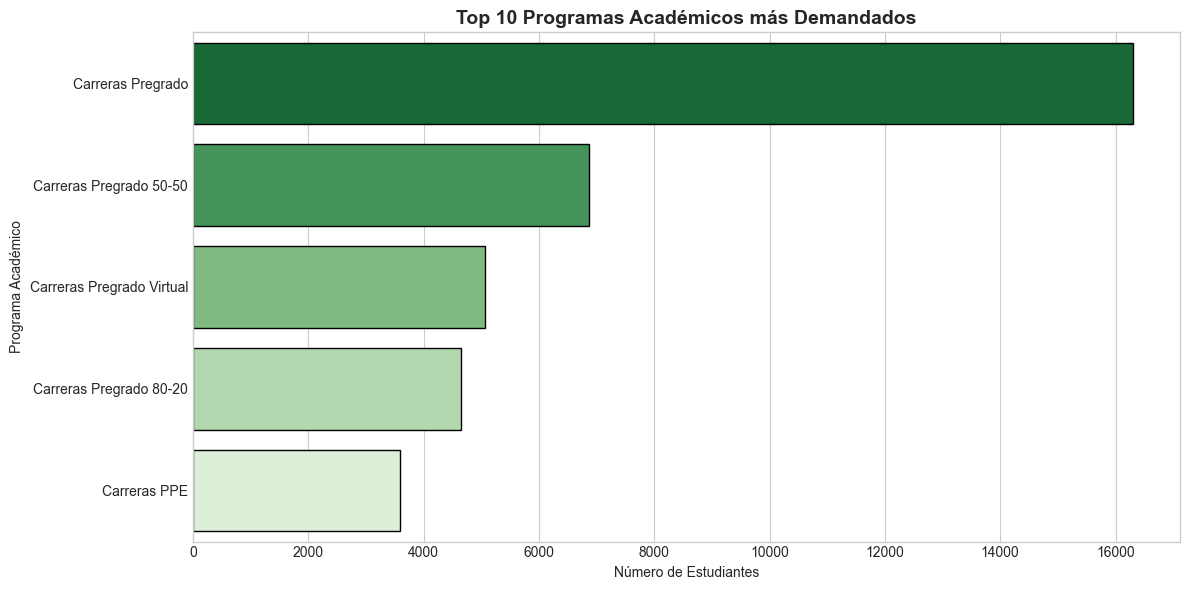

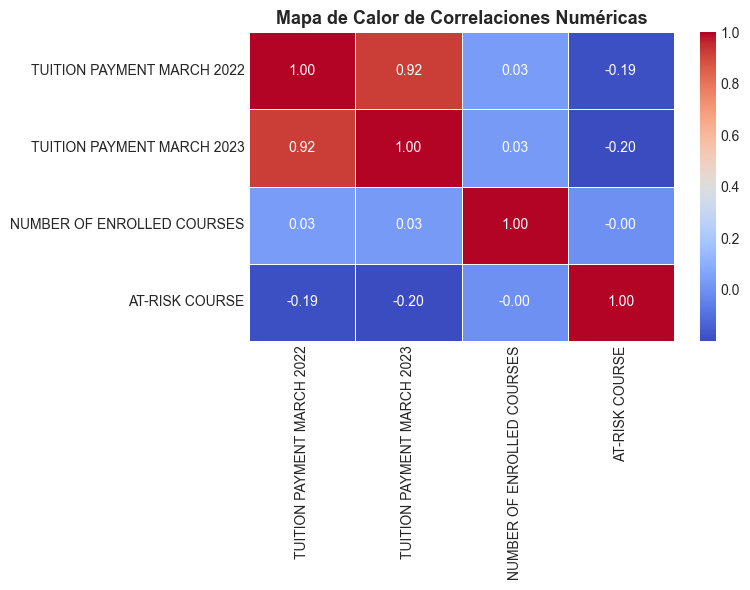

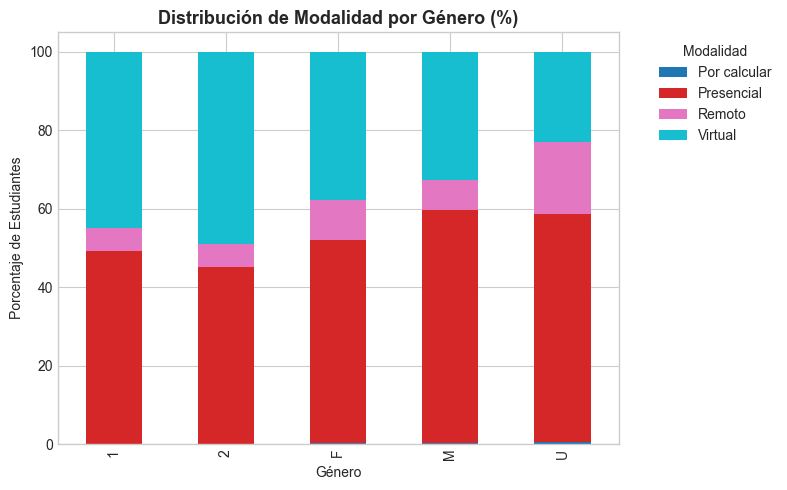

In [20]:

# 3.1 Estadísticas Generales

print(" 3.1 ESTADÍSTICAS GENERALES\n")

total_estudiantes = len(df_clean)
print(f"Total de estudiantes matriculados: {total_estudiantes:,}\n")

# Mostrar resumen estadístico general
print(df_clean.describe(include='all').transpose().head(10))
print("\n" + "-"*90 + "\n")

# ------------------------------------------------------
# 3.2 Distribución por Género
# ------------------------------------------------------
if 'GENDER' in df_clean.columns:
    print("📊 Distribución por Género:\n")
    genero_counts = df_clean['GENDER'].value_counts()
    for g, c in genero_counts.items():
        print(f"  • {g:20s}: {c:7,} ({c/total_estudiantes*100:5.2f}%)")
    
    plt.figure(figsize=(6, 5))
    plt.pie(genero_counts, labels=genero_counts.index, autopct='%1.1f%%',
            startangle=90, colors=['#66b3ff', '#ff9999', '#99ff99'])
    plt.title('Distribución de Matrícula por Género - 2023', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.savefig('00_genero.png', dpi=300, bbox_inches='tight')
    print("✓ Gráfico guardado: '00_genero.png'\n")

# ------------------------------------------------------
# 3.3 Distribución por Tipo de Institución
# ------------------------------------------------------
if 'TYPE OF EDUCATIONAL INSTITUTION' in df_clean.columns:
    tipo_counts = df_clean['TYPE OF EDUCATIONAL INSTITUTION'].value_counts()
    print("🏛️ Distribución por Tipo de Institución:\n")
    for t, c in tipo_counts.items():
        print(f"  • {t:30s}: {c:7,} ({c/total_estudiantes*100:5.2f}%)")
    
    plt.figure(figsize=(8, 5))
    sns.barplot(x=tipo_counts.values, y=tipo_counts.index, palette="pastel", edgecolor="black")
    plt.title("Distribución de Matrícula por Tipo de Institución", fontsize=13, fontweight='bold')
    plt.xlabel("Número de Estudiantes")
    plt.ylabel("Tipo de Institución")
    plt.tight_layout()
    plt.savefig('00_tipo_institucion.png', dpi=300, bbox_inches='tight')
    print("✓ Gráfico guardado: '00_tipo_institucion.png'\n")

# ------------------------------------------------------
# 3.4 Análisis Geográfico (Top 10)
# ------------------------------------------------------
if 'DEPARTMENT' in df_clean.columns:
    dept_counts = df_clean['DEPARTMENT'].value_counts().head(10)
    print("📍 Top 10 Departamentos por Matrícula:")
    for i, (dept, c) in enumerate(dept_counts.items(), 1):
        print(f"  {i:2d}. {dept:20s} → {c:7,} estudiantes ({c/total_estudiantes*100:5.2f}%)")
    
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x=dept_counts.values, y=dept_counts.index, palette="Blues_d")
    plt.title("Top 10 Departamentos por Matrícula", fontsize=14, fontweight='bold')
    plt.xlabel("Número de Estudiantes")
    plt.ylabel("Departamento")
    plt.tight_layout()
    plt.savefig('01_analisis_geografico.png', dpi=300, bbox_inches='tight')
    print("✓ Gráfico guardado: '01_analisis_geografico.png'\n")

# ------------------------------------------------------
# 3.5 Programas Académicos (Top 10)
# ------------------------------------------------------
if 'CLASSIFICATION' in df_clean.columns:
    program_counts = df_clean['CLASSIFICATION'].value_counts().head(10)
    print("🎓 Top 10 Programas Académicos más Demandados:\n")
    for i, (prog, c) in enumerate(program_counts.items(), 1):
        print(f"  {i:2d}. {prog[:45]:45s} → {c:7,} estudiantes ({c/total_estudiantes*100:5.2f}%)")
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=program_counts.values, y=program_counts.index, palette="Greens_r", edgecolor="black")
    plt.title("Top 10 Programas Académicos más Demandados", fontsize=14, fontweight='bold')
    plt.xlabel("Número de Estudiantes")
    plt.ylabel("Programa Académico")
    plt.tight_layout()
    plt.savefig('02_programas_academicos.png', dpi=300, bbox_inches='tight')
    print("✓ Gráfico guardado: '02_programas_academicos.png'\n")

# ------------------------------------------------------
# 3.6 Correlaciones Numéricas (si existen columnas numéricas)
# ------------------------------------------------------
num_cols = df_clean.select_dtypes(include=[np.number]).columns
if len(num_cols) > 1:
    print("📈 Correlación entre variables numéricas:\n")
    corr = df_clean[num_cols].corr()
    print(corr.round(2))
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title("Mapa de Calor de Correlaciones Numéricas", fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.savefig('03_correlaciones.png', dpi=300, bbox_inches='tight')
    print("✓ Gráfico guardado: '03_correlaciones.png'\n")

# ------------------------------------------------------
# 3.7 Cruce Modalidad vs Género (si existen ambas columnas)
# ------------------------------------------------------
if 'STUDY MODE' in df_clean.columns and 'GENDER' in df_clean.columns:
    cross = pd.crosstab(df_clean['GENDER'], df_clean['STUDY MODE'])
    print("📊 Relación entre Género y Modalidad de Estudio:\n")
    print(cross, "\n")
    
    cross_pct = (cross.T / cross.T.sum()).T * 100
    cross_pct.plot(kind='bar', stacked=True, figsize=(8, 5), colormap='tab10')
    plt.title("Distribución de Modalidad por Género (%)", fontsize=13, fontweight='bold')
    plt.ylabel("Porcentaje de Estudiantes")
    plt.xlabel("Género")
    plt.legend(title='Modalidad', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('03_modalidad_genero.png', dpi=300, bbox_inches='tight')
    print("✓ Gráfico guardado: '03_modalidad_genero.png'\n")

print("="*90 + "\n")


In [21]:
print("📊 FASE 4: ANÁLISIS ESTADÍSTICO\n")

# 4.1 Prueba Chi-cuadrado (Género vs Modalidad)
print("📈 4.1 PRUEBA CHI-CUADRADO: Independencia entre variables\n")

if 'GENDER' in df_clean.columns and 'STUDY MODE' in df_clean.columns:
    contingency_table = pd.crosstab(df_clean['GENDER'], df_clean['STUDY MODE'])
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    
    print(f"Análisis: Género vs Modalidad de Estudio")
    print(f"  • Chi-cuadrado: {chi2:.4f}")
    print(f"  • P-valor: {p_value:.6f}")
    print(f"  • Grados de libertad: {dof}")
    
    if p_value < 0.05:
        print(f"  • Conclusión: Existe relación significativa (p < 0.05) ✓")
    else:
        print(f"  • Conclusión: No hay relación significativa (p >= 0.05)")
    print()

# 4.2 Concentración geográfica (Índice de Herfindahl)
print("📈 4.2 ÍNDICE DE CONCENTRACIÓN GEOGRÁFICA\n")

if 'DEPARTMENT' in df_clean.columns:
    dept_shares = df_clean['DEPARTMENT'].value_counts() / total_estudiantes
    herfindahl_index = (dept_shares ** 2).sum()
    
    print(f"Índice de Herfindahl-Hirschman (HHI): {herfindahl_index:.4f}")
    print(f"  • Rango: 0 (totalmente disperso) a 1 (totalmente concentrado)")
    
    if herfindahl_index > 0.15:
        print(f"  • Interpretación: Alta concentración geográfica")
    elif herfindahl_index > 0.10:
        print(f"  • Interpretación: Concentración moderada")
    else:
        print(f"  • Interpretación: Baja concentración, distribución equilibrada")

print("\n" + "="*90 + "\n")

📊 FASE 4: ANÁLISIS ESTADÍSTICO

📈 4.1 PRUEBA CHI-CUADRADO: Independencia entre variables

Análisis: Género vs Modalidad de Estudio
  • Chi-cuadrado: 273.8296
  • P-valor: 0.000000
  • Grados de libertad: 12
  • Conclusión: Existe relación significativa (p < 0.05) ✓

📈 4.2 ÍNDICE DE CONCENTRACIÓN GEOGRÁFICA

Índice de Herfindahl-Hirschman (HHI): 0.3218
  • Rango: 0 (totalmente disperso) a 1 (totalmente concentrado)
  • Interpretación: Alta concentración geográfica




🤖 FASE 5: ANÁLISIS PREDICTIVO BÁSICO

Objetivo: Predecir la modalidad de estudio basado en características

✓ Dataset para modelado: 15,704 registros

📊 División de datos:
  • Entrenamiento: 11,778 registros (75.0%)
  • Prueba: 3,926 registros (25.0%)

🌳 Entrenando modelo Random Forest...
✓ Modelo entrenado exitosamente

📊 RESULTADOS DEL MODELO PREDICTIVO

✓ Accuracy (Precisión): 81.79%

📋 Reporte de Clasificación:
              precision    recall  f1-score   support

  Presencial       0.00      0.00      0.00         9
     Virtual       0.82      0.98      0.90      2985
Por calcular       0.50      0.03      0.05        37
      Remoto       0.78      0.31      0.44       895

    accuracy                           0.82      3926
   macro avg       0.52      0.33      0.35      3926
weighted avg       0.81      0.82      0.78      3926


🔍 Importancia de Características:
  CLASSIFICATION                           │ 0.8218 │ █████████████████████████████████████████
  DEPARTMENT   

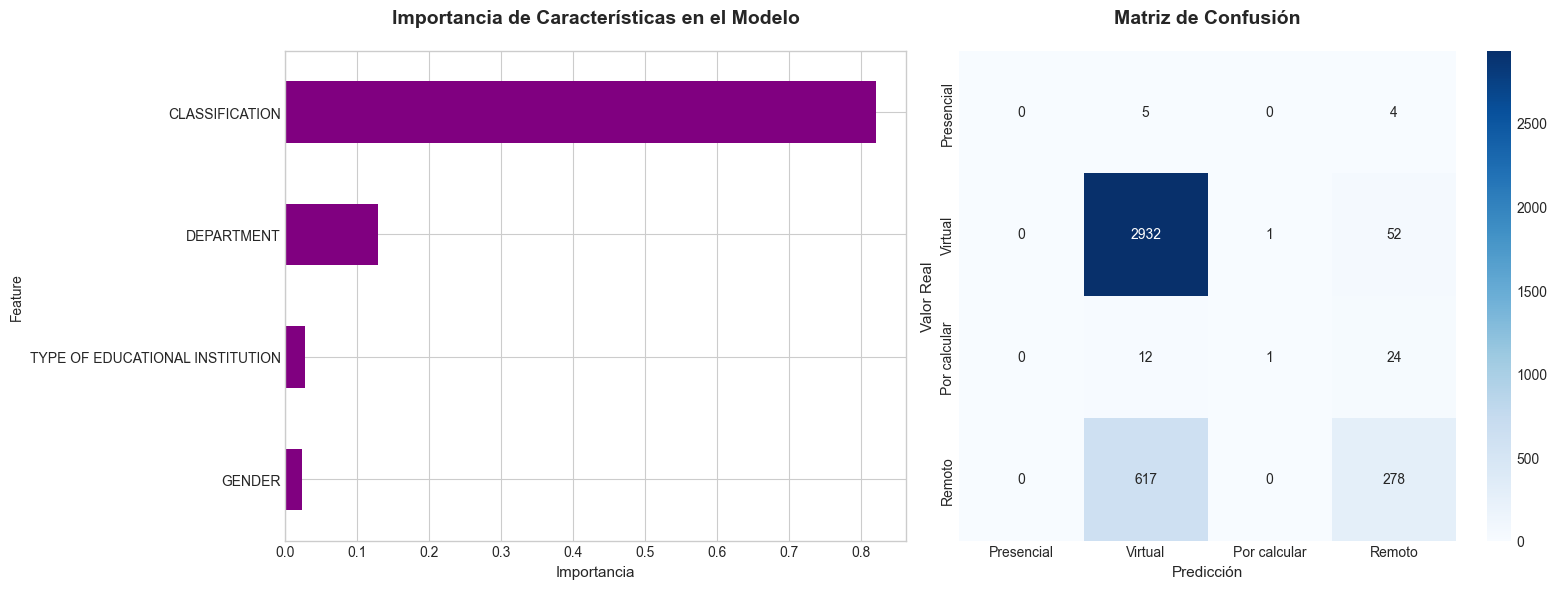

In [22]:
print("🤖 FASE 5: ANÁLISIS PREDICTIVO BÁSICO\n")
print("Objetivo: Predecir la modalidad de estudio basado en características\n")

# Preparar datos para modelo predictivo
if all(col in df_clean.columns for col in ['STUDY MODE', 'DEPARTMENT', 'CLASSIFICATION', 'GENDER']):
    
    # Seleccionar features y target
    features_cols = ['DEPARTMENT', 'CLASSIFICATION', 'GENDER', 'TYPE OF EDUCATIONAL INSTITUTION']
    features_cols = [col for col in features_cols if col in df_clean.columns]
    
    df_model = df_clean[features_cols + ['STUDY MODE']].copy()
    df_model = df_model.dropna()
    
    print(f"✓ Dataset para modelado: {len(df_model):,} registros\n")
    
    # Codificar variables categóricas
    le_dict = {}
    X = df_model[features_cols].copy()
    
    for col in features_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        le_dict[col] = le
    
    y = LabelEncoder().fit_transform(df_model['STUDY MODE'])
    study_mode_classes = df_model['STUDY MODE'].unique()
    
    # Dividir datos
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )
    
    print(f"📊 División de datos:")
    print(f"  • Entrenamiento: {len(X_train):,} registros ({len(X_train)/len(df_model)*100:.1f}%)")
    print(f"  • Prueba: {len(X_test):,} registros ({len(X_test)/len(df_model)*100:.1f}%)")
    print()
    
    # Entrenar modelo Random Forest
    print("🌳 Entrenando modelo Random Forest...")
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)
    print("✓ Modelo entrenado exitosamente\n")
    
    # Predicciones
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Resultados
    print("="*90)
    print("📊 RESULTADOS DEL MODELO PREDICTIVO")
    print("="*90)
    print(f"\n✓ Accuracy (Precisión): {accuracy:.2%}\n")
    
    print("📋 Reporte de Clasificación:")
    print(classification_report(y_test, y_pred, target_names=[str(c) for c in study_mode_classes]))
    
    # Importancia de características
    feature_importance = pd.DataFrame({
        'Feature': features_cols,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\n🔍 Importancia de Características:")
    for idx, row in feature_importance.iterrows():
        bar = '█' * int(row['Importance'] * 50)
        print(f"  {row['Feature']:40s} │ {row['Importance']:.4f} │ {bar}")
    
    # Visualización de importancia
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Importancia de features
    feature_importance.plot(x='Feature', y='Importance', kind='barh', 
                           ax=axes[0], color='purple', legend=False)
    axes[0].set_title('Importancia de Características en el Modelo', 
                     fontsize=14, fontweight='bold', pad=20)
    axes[0].set_xlabel('Importancia', fontsize=11)
    axes[0].invert_yaxis()
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
                xticklabels=study_mode_classes, yticklabels=study_mode_classes)
    axes[1].set_title('Matriz de Confusión', fontsize=14, fontweight='bold', pad=20)
    axes[1].set_xlabel('Predicción', fontsize=11)
    axes[1].set_ylabel('Valor Real', fontsize=11)
    
    plt.tight_layout()
    plt.savefig('04_modelo_predictivo.png', dpi=300, bbox_inches='tight')
    print(f"\n✓ Gráfico guardado: '04_modelo_predictivo.png'")
    
else:
    print("⚠️  No se pudieron encontrar todas las columnas necesarias para el modelo predictivo")

print("\n" + "="*90 + "\n")